# Alternative post-explanation processing

## Overview

The class introspection pipeline has an issue: it doesn't work nicely for everything. This is due to using PCA, which is very sensitive to outliers. This notebook will attempt to remove the outliers and use a single global PCA basis.

In [1]:
# CONFIG:

EPSILON  = 0.007
FILENAME = 'run_0_1.pickle'

## Initial Setup

 - Init libraries
 - Load in explanations


In [2]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

from scipy.stats import norm

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

import pickle
import os

PICKLES_PATH = '../pipeline/outputs/'

In [3]:
def load_explanations(filename):
    filename = os.path.join(PICKLES_PATH, filename)
    if not os.path.exists(filename):
        raise FileNotFoundError(f'file not found: {filename}')

    with open(filename, 'rb') as pickle_file:
        return pickle.load(pickle_file)

In [4]:
example = load_explanations(FILENAME)

In [5]:
example.keys()

dict_keys(['pair', 'y_trn_hw', 'y_tst_hw', 'model_name', 'metrics', 'shaps', 'time'])

In [6]:
# print every explanation set
for label in range(len(example['shaps'])):
    print(f"Label {label} shape: {example['shaps'][label].shape}")

Label 0 shape: (10000, 28, 28)
Label 1 shape: (10000, 28, 28)
Label 2 shape: (10000, 28, 28)
Label 3 shape: (10000, 28, 28)
Label 4 shape: (10000, 28, 28)
Label 5 shape: (10000, 28, 28)
Label 6 shape: (10000, 28, 28)
Label 7 shape: (10000, 28, 28)
Label 8 shape: (10000, 28, 28)
Label 9 shape: (10000, 28, 28)


## Computing Global PCA Components

As seen above, there are explanations for each label for each point. We are only interested in the labels that the network predicted, so let's use the `y_tst_hw` to create a hybrid listing of only the explanations that match predicted labels.

In [7]:
# nice & easy
batch = []
for i,label in enumerate(example['y_tst_hw']):
    label = int(label[0])
    batch.append(example['shaps'][label][i])
    
# convert to numpy array for posterity
batch = np.array(batch)

# should be (10000, 28, 28)
print(f'batch shape: {batch.shape}')

batch shape: (10000, 28, 28)


### Sidebar: Outlier Detection

From previous observations, a small number of SHAP outputs have *very high* maximum value—several orders of magnitude larger than expected. Let's plot the distribution of the maximum values of our explanations.

In [8]:
maximums = np.zeros(10000)
for i in range(batch.shape[0]):
    maximums[i] = np.amax(batch[i])
sorted_maximums_idxs = np.flip(np.argsort(maximums))

In [9]:
mean   = np.mean(maximums)
stddev = np.std( maximums)

print(f'mean:   {mean}')
print(f'stddev: {stddev}')

mean:   0.02573081189902732
stddev: 0.08596389377230669


In [10]:
# find the indices that are more than 1 standard deviation away from the mean
outliers = np.logical_or(maximums < mean - stddev, maximums > mean + stddev)

In [11]:
outlier_indices = np.nonzero(outliers)
print(outlier_indices)
# outlier_indices = []

(array([   4,   48,  339,  433,  447,  483,  552,  578,  727,  817, 1173,
       1245, 1270, 1319, 1332, 1516, 1721, 1730, 1762, 1839, 1941, 2066,
       2115, 2296, 2369, 2414, 2460, 2524, 2571, 2916, 3037, 3398, 3799,
       3962, 3985, 4078, 4093, 4240, 4266, 4355, 4630, 4941, 4981, 5068,
       5547, 5626, 5643, 5934, 6045, 6050, 6059, 6323, 6421, 6619, 6621,
       6671, 6870, 7043, 7360, 7627, 7698, 7758, 7812, 8213, 8339, 8706,
       9168, 9209, 9534, 9879, 9891]),)


In [12]:
print(f'Outlier count: {np.count_nonzero(outliers)}')
print(f'Outlier %-age: {100 * np.count_nonzero(outliers)/len(maximums)}%')

Outlier count: 71
Outlier %-age: 0.71%


As expected, there are only a few numbers that are far away from the mean.

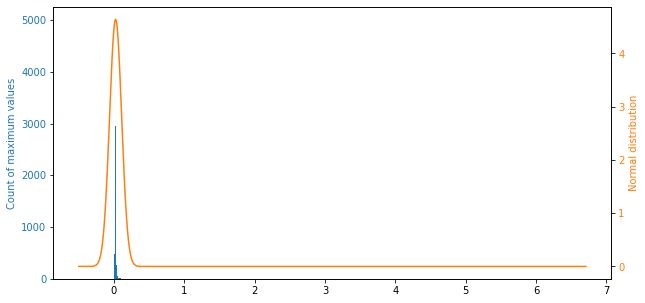

In [13]:
# pyplot setup
fig, ax1 = plt.subplots()

# histogram of maximum values
color = 'tab:blue'
ax1.hist(maximums, bins=1000, label='histogram of data', color=color)
ax1.set_ylabel('Count of maximum values', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# second plot
ax2 = ax1.twinx()

# attempt to draw a normal distribution (likely too small)
color = 'tab:orange'
x_axis = np.arange(np.amin(maximums) - 0.5, np.amax(maximums), 0.0001)
ax2.plot(x_axis, norm.pdf(x_axis,mean,stddev), color=color)
ax2.set_ylabel('Normal distribution', color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.show()

Plotting the distribution yields very little meaningful data, as there are just too many points on the histogram.

### Computing global PCA components

Now that we have a list of outlier indicices (from `outlier_indices`), let's create a set of global PCA basis vectors.

In [14]:
batch_filtered = np.delete(batch, outlier_indices, axis=0)
print(f'Filtered batch of explanations has shape {batch_filtered.shape}')

Filtered batch of explanations has shape (9929, 28, 28)


We'll also need to filter the labels to make sure they still line up with the explanations:

In [15]:
y_tst_hw_filtered = np.delete(example['y_tst_hw'], outlier_indices, axis=0)

In [16]:
y_tst_hw_filtered.shape

(9929, 1)

Next, create the PCA vectors by feeding in the whole batch into the decomposer, and transform the batch into the space:

In [17]:
pca = PCA(n_components=5)
batch_tfrm = pca.fit_transform([e.flatten() for e in batch_filtered])

In [18]:
batch_tfrm.shape

(9929, 5)

## Clustering using DBSCAN

As before, we can cluster with DBSCAN. Let's pick label `0`, as this is the bridged label in the `(0,1)` case.

In [19]:
# select the explanations with a label of 0
bt_indices_0, _ = np.where(y_tst_hw_filtered == 0)
bt_lbl_0 = batch_tfrm[bt_indices_0]

0101101100001110110001101010001010000110001100001000100011010111101110110000010001110010001000100111010001011000110111111011111011011001200000001111111001001001000000101001000000101111101111000010010001101001011001000001000101001101000011100111011010001111000100112011010000010000001100111111000110111001101110111001110110111100100100100111001110110001101010111100011110100000011000110001010101000101101000100001101001011101111100010000101111110100100001010001101001011110000000011101101010010001011101110110101100110011001011111011100010010001111000100110011111100010100110100111100011000111010011010001101010101001111010111100000110001011111010011100001101000011010001111011011110001111000111100000001111000110010111011001111001001111010010100100100101011011101110001011000001111001101100010111010111010001110110100001001001110011101101001110110000010101110100000011000111010100000111100000110100110111110111011110111110111000110011000000000010111111100100001010000001010001101100101110111001001000

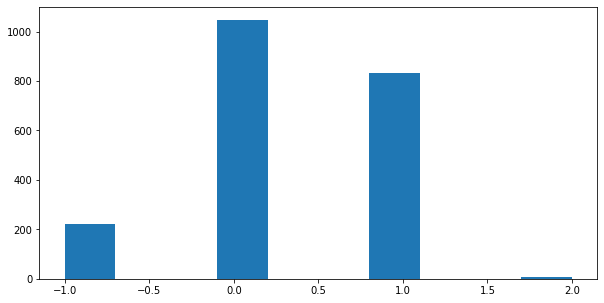

In [20]:
# EPSILON = 0.005

dbscan_0 = DBSCAN(eps=EPSILON)
vals_0 = dbscan_0.fit_predict(bt_lbl_0)
print(''.join([str(abs(v)) for v in vals_0]))

plt.hist(vals_0)
plt.show()

Looks promising!

## DBSCAN over all labels

In [21]:
def get_transformed_instances(lbl):
    bt_indices, _ = np.where(y_tst_hw_filtered == lbl)
    return batch_tfrm[bt_indices]

def create_single_graph(ax, lbl, epsilon, silent=False):
#     bt_indices, _ = np.where(y_tst_hw_filtered == lbl)
    bt_lbl = get_transformed_instances(lbl)
    
    dbscan = DBSCAN(eps=epsilon)
    vals = dbscan.fit_predict(bt_lbl)
    
    if not silent:
        print(''.join([str(abs(v)) for v in vals]))

    # heavy wizardry to indicate noise
    _, _, patches = ax.hist(vals, label=f'{int(lbl)}')
    patches[0].set_facecolor('gray')
    ax.legend()
    return ax

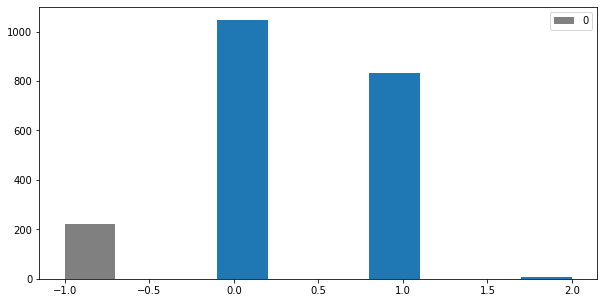

In [22]:
create_single_graph(plt, 0, EPSILON, silent=True)
plt.show()

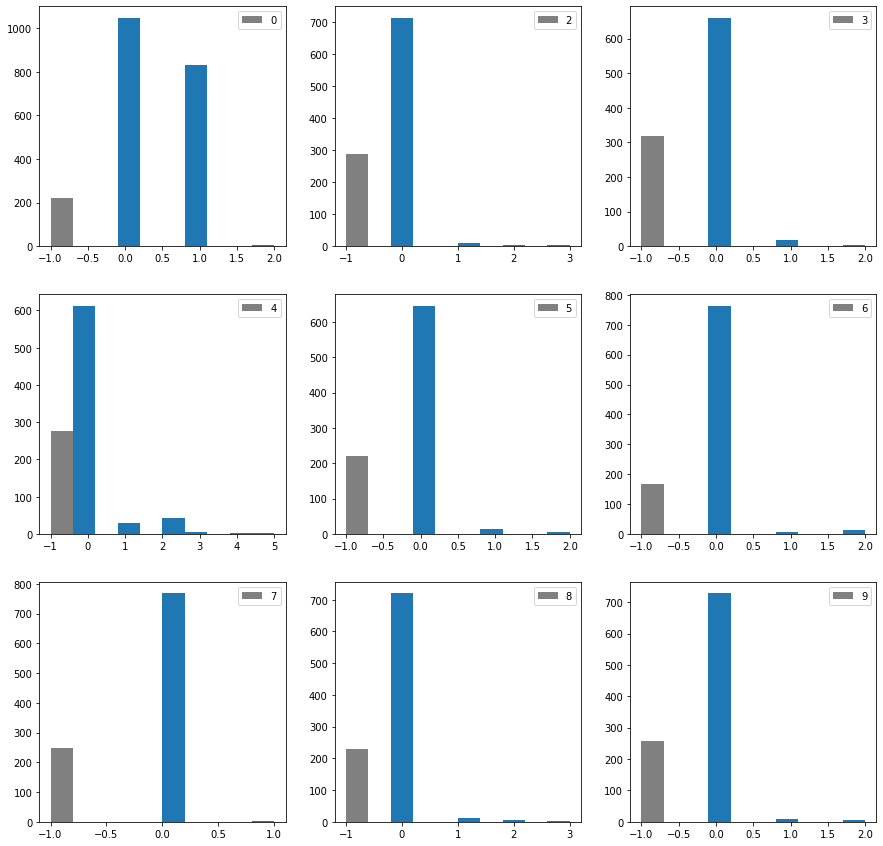

In [23]:
# one big graph
plt.rcParams['figure.figsize'] = [15, 15]

fig, axs = plt.subplots(3,3)
axs_r = axs.ravel() # iterate over these without structure

# zip together the axes with the labels that go on them
for lbl, ax in zip(np.unique(y_tst_hw_filtered), axs_r):
    create_single_graph(ax, lbl, EPSILON, silent=True)

plt.show()

In these graphs, the noise is at -1 and is marked with a gray color. Every single one has a mostly a single bar—**except for the bridged case!**

## Variances:



In [24]:
min_length = min([len(get_transformed_instances(i)) for i in np.unique(y_tst_hw_filtered)])
print(min_length)
x_axis = np.array([i for i in range(10)])
y_axis = np.zeros(10)
for i in np.unique(y_tst_hw_filtered):
    var = np.var(get_transformed_instances(i)[:min_length])
    print(f'label {i} variance: {var}')
    y_axis[int(i)] = var

886
label 0.0 variance: 0.0002846768347990689
label 2.0 variance: 0.0001495945676188864
label 3.0 variance: 0.00019419178689852185
label 4.0 variance: 0.0002361823793111916
label 5.0 variance: 0.0002505785617666032
label 6.0 variance: 0.00022977938426954752
label 7.0 variance: 0.00017618810429306708
label 8.0 variance: 0.00010479683388907717
label 9.0 variance: 0.00017747372711804065


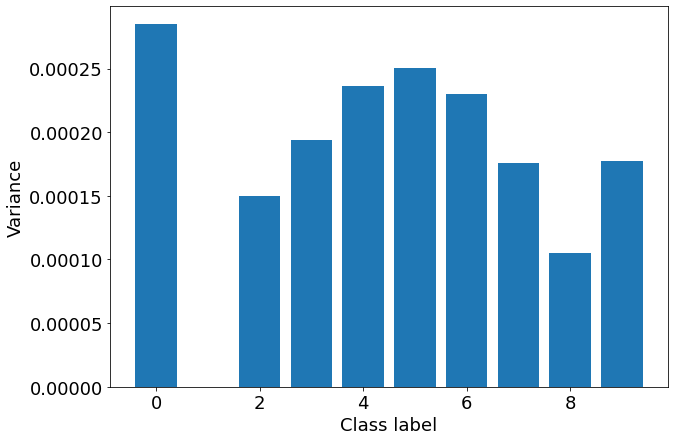

In [27]:
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['font.size'] = 18
plt.xlabel('Class label')
plt.ylabel('Variance')

plt.bar(x_axis, y_axis)
plt.show()